### OSF Cough Audio Classifier with Deep Learning

Build a CNN sound classifier (transfer learning from pretrained VGGish model) using melspectograms from OSF cough audio dataset.

In [1]:
%matplotlib inline
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import multi_gpu_model
import numpy as np
import json
import PIL

In [2]:
from vggish_params import *
from vggish import *

In [3]:
from __future__ import print_function
from __future__ import absolute_import

import sys

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras import backend as K

import vggish_params as params

# weight path
WEIGHTS_PATH = '/Users/xt/Desktop/OSF/vggish_audioset_weights_without_fc2.h5'
WEIGHTS_PATH_TOP = '/Users/xt/Desktop/OSF/vggish_audioset_weights.h5'

def VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=True, pooling='max'):
    '''
    An implementation of the VGGish architecture.

    :param load_weights: if load weights
    :param weights: loads weights pre-trained on a preliminary version of YouTube-8M.
    :param input_tensor: input_layer
    :param input_shape: input data shape
    :param out_dim: output dimension
    :param include_top:whether to include the 3 fully-connected layers at the top of the network.
    :param pooling: pooling type over the non-top network, 'avg' or 'max'

    :return: A Keras model instance.
    '''

    if weights not in {'audioset', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `audioset` '
                         '(pre-training on audioset).')

    if out_dim is None:
        out_dim = params.EMBEDDING_SIZE

    # input shape
    if input_shape is None:
        input_shape = (params.NUM_FRAMES, params.NUM_BANDS, 1)

    if input_tensor is None:
        aud_input = Input(shape=input_shape, name='input_1')
    else:
        if not K.is_keras_tensor(input_tensor):
            aud_input = Input(tensor=input_tensor, shape=input_shape, name='input_1')
        else:
            aud_input = input_tensor

    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv1')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_1')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_1')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)

    if include_top:
        # FC block
        x = Flatten(name='flatten_')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_1')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_2')(x)
        x = Dense(out_dim, activation='relu', name='vggish_fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = aud_input
    # Create model.
    model = Model(inputs, x, name='VGGish')

    # load weights
    if load_weights:
        if weights == 'audioset':
            if include_top:
                model.load_weights(WEIGHTS_PATH_TOP)
            else:
                model.load_weights(WEIGHTS_PATH)
        else:
            print("failed to load weights")

    return model

# Set parameter values

In [4]:
batch_size = 128
epochs = 50

# dimensions of our images.
img_width, img_height = 128, 128

input_tensor = Input(shape=(128,128,1))

nb_training_samples = 3716
nb_validation_samples = 1219# Set parameter values

# Configure training and validation data generators

Provide paths to training and testing set directores

In [5]:
# training generator configuration
training_data_dir = '/Users/xt/Desktop/OSF/melspectrograms/train/'


#img = img.resize((w, h), Image.LANCZOS).convert('L')
#image_np = np.array(img )
#image_np = np.expand_dims(image_np, -1)


training_datagen = image.ImageDataGenerator(
    rescale=1./255) #, rotation_range = 90)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,color_mode="grayscale", shuffle=True)

# validation generator configuration
validation_data_dir ='/Users/xt/Desktop/OSF/melspectrograms/validation/'

validation_datagen = image.ImageDataGenerator(
    rescale=1./255) #, rotation_range = 90)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size, color_mode="grayscale", shuffle=True)

Found 3716 images belonging to 2 classes.
Found 1219 images belonging to 2 classes.


# Load base model

In [6]:
base_model = VGGish(include_top=False, load_weights=True)
print('Model loaded.')
base_model.summary()

Model loaded.
Model: "VGGish"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv3/conv3_1 (Conv2D)       (None, 32, 32, 256)       295168    
_________________________________________________________________
conv3/conv3_2 (Conv2D)       (None, 32, 32, 25

# Build top model

In [7]:
# build a classifier model to put on top of the convolutional model
from tensorflow.keras import initializers

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01)))
top_model.add(Dropout(0.2))
top_model.add(Dense(128, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01)))
top_model.add(Dropout(0.2))
top_model.add(Dense(2, activation='softmax'))
top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
__________________________________________________

# Combine base model with top model

In [8]:
# top_model.load_weights('bootlneck_fc_model.h5')
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# Configure model training

In [9]:
from keras import metrics, optimizers

def top_1_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=1)

#for layer in model.layers[:num_layers_to_freeze]:
#    layer.trainable = False

for layers in base_model.layers:
    layers.trainable = False

# use nesterov accelrated gradient descent ??
# optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)

#model.compile(optimizer=optimizers.SGD(lr=2e-5, momentum=0.9), 
#                      loss='categorical_crossentropy', 
#                      metrics=['accuracy', top_1_accuracy])

model.compile(optimizer=optimizers.Adam(), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy', top_1_accuracy])

# parallel_model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
#                       loss='categorical_crossentropy', 
#                       metrics=['accuracy', top_1_accuracy])

# serialize model to JSON
model_json = model.to_json()
#model_filename = "vggish_model_{}_frozen_layers.json".format(num_layers_to_freeze)
model_filename = "vggish_model_frozen_layers.json"

with open(model_filename, "w") as json_file:
    json_file.write(model_json)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv3/conv3_1 (Conv2D)       (None, 32, 32, 256)       295168    
_________________________________________________________________
conv3/conv3_2 (Conv2D)       (None, 32, 32, 256)       590080

# Fine-tune the model

In [11]:
#for layers in base_model.layers:
#    print(layers)

In [12]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from time import time
from plot_keras_history import plot_history

#tensorboard = TensorBoard(log_dir="logs/layers_frozen_{}".format(num_layers_to_freeze))
tensorboard = TensorBoard(log_dir="logs/layers_frozen")

# checkpoint
filepath="osf_vggish_weights_train_last_layers.best.hdf5"
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard]

# parallel_model.fit_generator(
#     training_generator,
#     steps_per_epoch=nb_training_samples/batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples/batch_size,
#     callbacks=callbacks_list)

model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)
# parallel_model.fit_generator(
#     training_generator,
#     samples_per_epoch=nb_training_samples,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples/batch_size,)
#     nb_val_samples=nb_validation_samples)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
30/29 [===============================] - 105s 4s/step - loss: 0.6592 - accuracy: 0.6103 - top_1_accuracy: 0.6103 - val_loss: 0.6248 - val_accuracy: 0.6169 - val_top_1_accuracy: 0.6169
Epoch 2/50
30/29 [===============================] - 103s 3s/step - loss: 0.6069 - accuracy: 0.6531 - top_1_accuracy: 0.6531 - val_loss: 0.5673 - val_accuracy: 0.7022 - val_top_1_accuracy: 0.7022
Epoch 3/50
30/29 [===============================] - 105s 3s/step - loss: 0.5685 - accuracy: 0.6940 - top_1_accuracy: 0.6940 - val_loss: 0.5566 - val_accuracy: 0.6924 - val_top_1_accuracy: 0.6924
Epoch 4/50
30/29 [===============================] - 106s 4s/step - loss: 0.5701 - accuracy: 0.6967 - top_1_accuracy: 0.6967 - val_loss: 0.5919 - val_accuracy: 0.6579 - val_top_1_accuracy: 0.6579
Epoch 5/50
30/29 [===============================] - 105s 4s/step - loss: 0.5549 - accuracy: 0.7034 - top_1_accuracy: 0.7034 - val_loss: 0.5

Epoch 22/50
30/29 [===============================] - 103s 3s/step - loss: 0.5086 - accuracy: 0.7398 - top_1_accuracy: 0.7398 - val_loss: 0.5167 - val_accuracy: 0.7276 - val_top_1_accuracy: 0.7276
Epoch 23/50
30/29 [===============================] - 104s 3s/step - loss: 0.5087 - accuracy: 0.7417 - top_1_accuracy: 0.7417 - val_loss: 0.5073 - val_accuracy: 0.7334 - val_top_1_accuracy: 0.7334
Epoch 24/50
30/29 [===============================] - 104s 3s/step - loss: 0.5058 - accuracy: 0.7384 - top_1_accuracy: 0.7384 - val_loss: 0.5105 - val_accuracy: 0.7301 - val_top_1_accuracy: 0.7301
Epoch 25/50
30/29 [===============================] - 104s 3s/step - loss: 0.5039 - accuracy: 0.7398 - top_1_accuracy: 0.7398 - val_loss: 0.5053 - val_accuracy: 0.7252 - val_top_1_accuracy: 0.7252
Epoch 26/50
30/29 [===============================] - 105s 3s/step - loss: 0.5058 - accuracy: 0.7446 - top_1_accuracy: 0.7446 - val_loss: 0.5111 - val_accuracy: 0.7334 - val_top_1_accuracy: 0.7334
Epoch 27/50
30/

30/29 [===============================] - 107s 4s/step - loss: 0.4998 - accuracy: 0.7403 - top_1_accuracy: 0.7403 - val_loss: 0.5036 - val_accuracy: 0.7408 - val_top_1_accuracy: 0.7408
Epoch 44/50
30/29 [===============================] - 107s 4s/step - loss: 0.4939 - accuracy: 0.7497 - top_1_accuracy: 0.7497 - val_loss: 0.5143 - val_accuracy: 0.7375 - val_top_1_accuracy: 0.7375
Epoch 45/50
30/29 [===============================] - 107s 4s/step - loss: 0.4939 - accuracy: 0.7425 - top_1_accuracy: 0.7425 - val_loss: 0.5013 - val_accuracy: 0.7391 - val_top_1_accuracy: 0.7391
Epoch 46/50
30/29 [===============================] - 106s 4s/step - loss: 0.4890 - accuracy: 0.7527 - top_1_accuracy: 0.7527 - val_loss: 0.4972 - val_accuracy: 0.7358 - val_top_1_accuracy: 0.7358
Epoch 47/50
30/29 [===============================] - 114s 4s/step - loss: 0.4869 - accuracy: 0.7554 - top_1_accuracy: 0.7554 - val_loss: 0.5155 - val_accuracy: 0.7367 - val_top_1_accuracy: 0.7367
Epoch 48/50
30/29 [========

# Get top k predictions for selected test files

In [13]:
def get_top_k_predictions(preds, label_map, k=1, print_flag=False):
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    label_map_flip = dict((v,k) for k,v in label_map.items())
    
    y_pred = []
    for label_index in top_k:
        if print_flag:
            print ("{} ({})".format(label_map_flip[label_index], preds[label_index]))
        y_pred.append(label_map_flip[label_index])
        
    return y_pred

In [14]:
label_map = (training_generator.class_indices)
 
json2 = json.dumps(label_map)
f = open("cough_label_map.json","w")
f.write(json2)
f.close()

img_path = '/Users/xt/Desktop/OSF/melspectrograms/test/sick/audioset__3RvCwwIZ4w_10_15.png'
img = image.load_img(img_path, target_size=(128,128), color_mode="grayscale")
#x = image.random_rotation(image.img_to_array(img), rg = 90)
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)* 1./255

preds = model.predict(x)[0]

get_top_k_predictions(preds, label_map, k=1)

['sick']

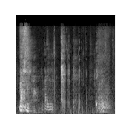

In [15]:
img

# Calculate and plot confusion matrix

In [16]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(24,24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Normalized confusion matrix


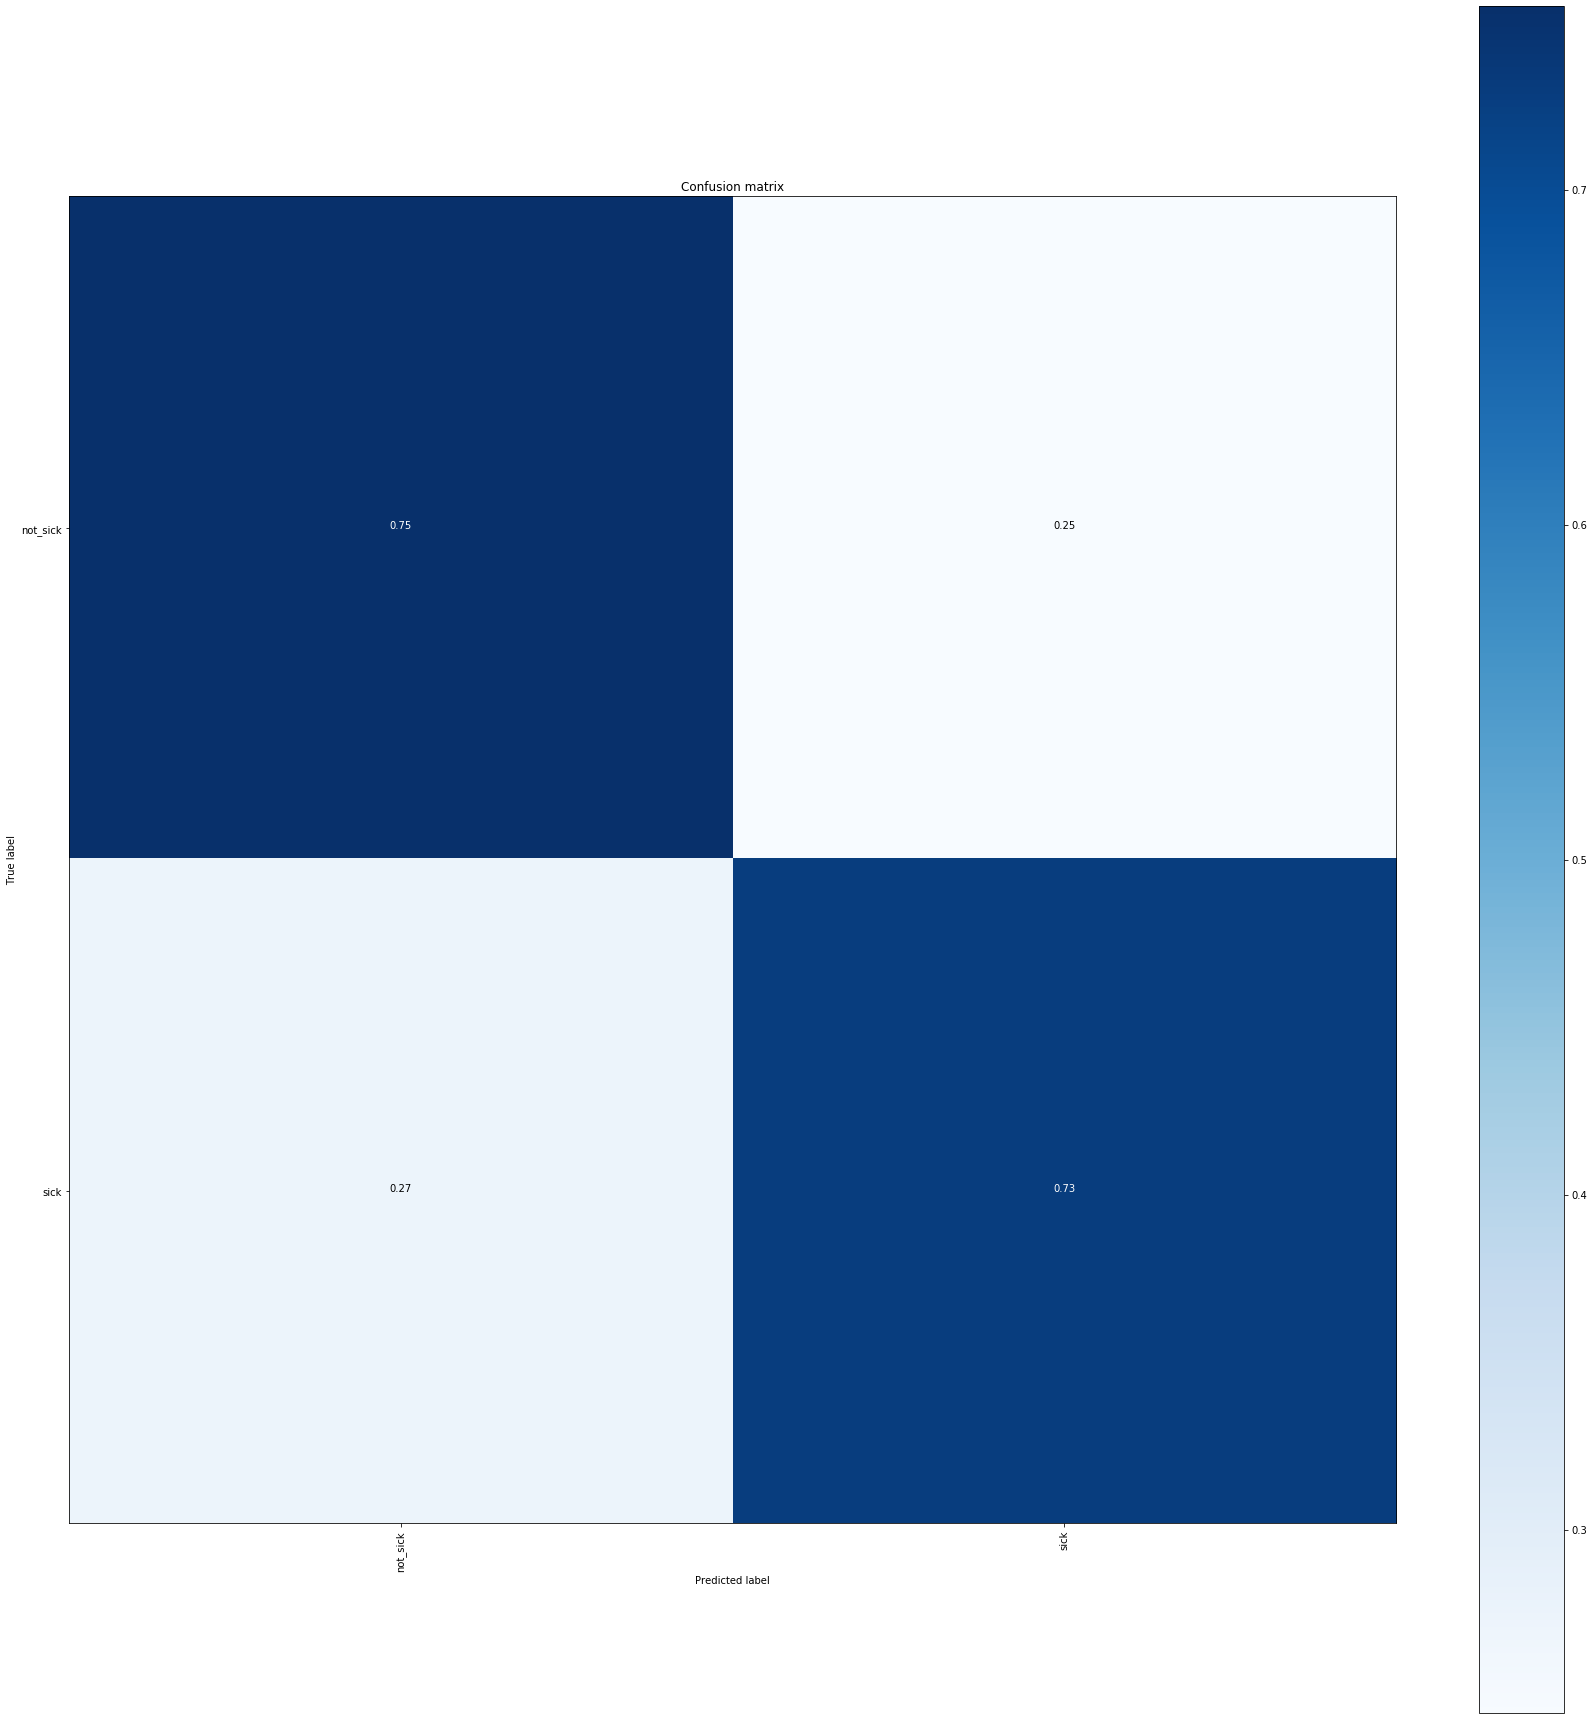

In [17]:
import os
import io
import requests
import urllib.request
from PIL import Image
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix

testing_dir = '/Users/xt/Desktop/OSF/melspectrograms/test/'

y_true = []
y_pred = []
for label in label_map.keys():
    file_list = os.listdir(testing_dir + label)
    for file_name in file_list:
        if file_name != '.DS_Store':
            img_path = testing_dir + label + '/' + file_name
            img = image.load_img(img_path, target_size=(128,128), color_mode="grayscale")
            
            x = image.img_to_array(img)
            #x = image.random_rotation(image.img_to_array(img), rg = 90)
            x = np.expand_dims(x, axis=0)* 1./255
    
            preds = model.predict(x)[0]
            
            y_true.append(label)
            y_pred.append(get_top_k_predictions(preds, label_map, k=1)[0])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(label_map.keys()), normalize=True)